## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [4]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
import numpy as np
import random
import math
from sklearn.metrics import accuracy_score

def gini(sequence):
    if len(sequence) == 0:
        return 0
    c_1=0
    for i in range(len(sequence)):
        if(sequence[i]==1):
            c_1 = c_1+1
    p=c_1/len(sequence)
    return 1 - p*p - (1-p)*(1-p)


def entropy(a):
    if len(a) == 0:
        return 0
    c_1=0
    for i in range(len(a)):
        if(a[i]==1):
            c_1 = c_1+1
    p=c_1/len(a)
    if p==0 or p==1 :
        return 0
    else: 
        return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

KeyboardInterrupt: 

In [232]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [233]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [234]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [5]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)
train_df.head()

train = train_df.values.tolist()
train = np.array(train)
x_data=train[:,:20]
y_data=train[:,20:].flatten()

val = val_df.values.tolist()
val = np.array(val)
x_val=val[:,:20]
y_val=val[:,20:].flatten()

(1200, 21)
(300, 21)


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [236]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    def is_leaf(self):
        return self.value is not None
def test_split(std_row , std , data,y):
    left = list()
    right = list()
    column = data.shape[0]
    for i in range(column):
        if data[i][std_row] < std:
            left.append(y[i])
        else:
            right.append(y[i])
    return left , right 
	
def get_split(train,y,jud):
    row = train.shape[1]
    b_row, b_value, b_score = None, 99999, 999
    for i in range(row):
        x_f = train[:,i]
        values = np.unique(x_f)
        for value in values:
            left , right = test_split(i, value, train, y)
            left_n = len(left) 
            right_n = len(right) 
            total_n = left_n + right_n
            if (jud==0):
                left_gini_value = (gini(left)*left_n)/total_n
                right_gini_value = (gini(right)*right_n)/total_n
            else:
                left_gini_value = (entropy(left)*left_n)/total_n
                right_gini_value = (entropy(right)*right_n)/total_n
            gini_value = left_gini_value + right_gini_value
            if gini_value < b_score:
                b_row, b_value, b_score = i, value ,gini_value 
    return b_row , b_value

def get_random_split(train,y,jud,feat):
    row = train.shape[1]
    idxs = np.random.choice(row, feat, replace=False)
    b_row, b_value, b_score = None, 99999, 999
    for i in idxs:
        x_f = train[:,i]
        values = np.unique(x_f)
        for value in values:
            left , right = test_split(i, value, train, y)
            left_n = len(left) 
            right_n = len(right) 
            total_n = left_n + right_n
            if (jud==0):
                left_gini_value = (gini(left)*left_n)/total_n
                right_gini_value = (gini(right)*right_n)/total_n
            else:
                left_gini_value = (entropy(left)*left_n)/total_n
                right_gini_value = (entropy(right)*right_n)/total_n
            gini_value = left_gini_value + right_gini_value
            if gini_value < b_score:
                b_row, b_value, b_score = i, value ,gini_value 
    return b_row , b_value


class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.max_depth = max_depth
        self.criterion = criterion
        self.root = None
        self.rows=[]
        self.random=0
        self.feat=0

    def fit(self, x_data, y_data):
        self.root = self.build_tree(x_data, y_data)

    def predict(self, x_data):
        predictions = [self.traverse_tree(x, self.root) for x in x_data]
        return np.array(predictions)

    def create_split(self, X, value):
        left_idx = np.argwhere(X < value).flatten()
        right_idx = np.argwhere(X >= value).flatten()
        return left_idx, right_idx



    def is_finished(self, depth):
        if (depth >= self.max_depth or self.n_class_labels == 1):
            return True
        return False


    def build_tree(self, X, y, depth=0):
        self.n_class_labels = len(np.unique(y))
        if self.is_finished(depth):
            #print("no")
            temp = len(y)
            if temp==0:
                return Node(value=0)
            else:
                if ((np.sum(y)/temp)>0.5):
                    #print(".1")
                    return Node(value=1)
                else:
                    #print(".0")
                    return Node(value=0)

        if self.random == 0:
            if(self.criterion=='gini'):
                best_row, best_value = get_split(X,y,0)
            else:
                best_row, best_value = get_split(X,y,1)
        else:
            if(self.criterion=='gini'):
                best_row, best_value = get_random_split(X,y,0,self.feat)
            else:
                best_row, best_value = get_random_split(X,y,1,self.feat)
        


        #print(best_row,best_value)
        self.rows.append(best_row)
        left_idx, right_idx = self.create_split(X[:, best_row], best_value)
        left_child = self.build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right_child = self.build_tree(X[right_idx, :], y[right_idx], depth + 1)
        return Node(best_row, best_value, left_child, right_child)

    def traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] < node.threshold:
            #print("left")
            return self.traverse_tree(x, node.left)
        #print("right")
        return self.traverse_tree(x, node.right)
    
    def RF (self,feat):
        self.random=1
        self.feat=feat


### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [237]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

clf_depth3.fit(x_data, y_data)
clf_depth10.fit(x_data, y_data)

pred_3 = clf_depth3.predict(x_val)
pred_10 = clf_depth10.predict(x_val)

acc_3=accuracy_score(y_val, pred_3)
acc_10=accuracy_score(y_val, pred_10)

print(f"Accuracy of depth=3 {acc_3}")
print(f"Accuracy of depth=10 {acc_10}")

Accuracy of depth=3 0.92
Accuracy of depth=10 0.93


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [238]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

clf_gini.fit(x_data, y_data)
clf_entropy.fit(x_data, y_data)

pred_g = clf_gini.predict(x_val)
pred_e = clf_entropy.predict(x_val)

acc_g=accuracy_score(y_val, pred_g)
acc_e=accuracy_score(y_val, pred_e)

print(f"Accuracy of gini {acc_g}")
print(f"Accuracy of entropy {acc_e}")

Accuracy of gini 0.92
Accuracy of entropy 0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

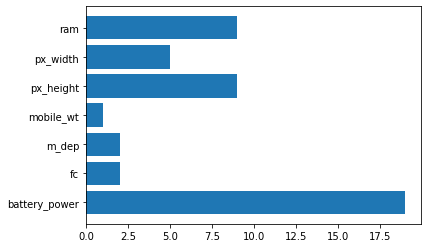

In [239]:
import matplotlib.pyplot as plt

quan = np.zeros(20)
for i in range(len(clf_depth10.rows)):
    quan[clf_depth10.rows[i]]+=1
#print(quan)
name = list(train_df)
left=list()
height=list()
for i in range(len(quan)):
    if not quan[i] ==0:
        left.append(name[i])
        height.append(quan[i])
left = np.array(left)
height = np.array(height)
plt.barh(left, height)
plt.show()



## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [240]:
class AdaBoost():
    def __init__(self, n_estimators):
        self.n_clf = n_estimators

    def fit(self, Ｘ, y):
        x_data = X
        y_data = y
        n_samples, n_features = X.shape
        self.clfs = []
        self.alp = []
        w = np.full(n_samples, (1 / n_samples))
        for _ in range(self.n_clf):
            clf = DecisionTree(max_depth=1)
            clf.fit(x_data, y_data)
            pred = clf.predict(X)
            misclassified = w[y != pred]
            error = sum(misclassified)
            #print(error)
            EPS = 1e-10
            a = 0.5 * np.log((1.0 - error + EPS) / (error + EPS))
            #print(a)
            self.alp.append(a)
            for i in range(len(w)):
                if y[i]==pred[i]:
                    w[i]*= math.exp(-a)
                else:
                    w[i]*= math.exp(a)
            w /= np.sum(w)
            self.clfs.append(clf)
            x_data = list()
            y_data = list()
            for i in range(n_samples):
                r = random.random()
                total=0
                index=0
                for k in range(n_samples):
                    total+=w[k]
                    if total >= r :
                        index=k
                        break
                x_data.append(X[index])
                y_data.append(y[index])
            x_data = np.array(x_data)
            y_data = np.array(y_data)


    def predict(self, Ｘ):
        n_samples, n_features = X.shape
        clf_preds = np.zeros(n_samples)
        for i in range(self.n_clf):
            pred_t=self.clfs[i].predict(X)
            for j in range(len(pred_t)):
                if pred_t[j]==0:
                    pred_t[j]=-1
            clf_preds += self.alp[i]*pred_t
        for i in range(len(clf_preds)):
            if clf_preds[i]>=0:
                clf_preds[i]=1
            else:
                clf_preds[i]=0
        return clf_preds

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [241]:
ada_10 = AdaBoost(n_estimators=10)
ada_100 = AdaBoost(n_estimators=100)

ada_10.fit(x_data, y_data)
ada_100.fit(x_data, y_data)

pred_a10 = ada_10.predict(x_val)
pred_a100 = ada_100.predict(x_val)

acc_a10=accuracy_score(y_val, pred_a10)
acc_a100=accuracy_score(y_val, pred_a100)

print(f"Accuracy of n_estimators=10 {acc_a10}")
print(f"Accuracy of n_estimators=100 {acc_a100}")

Accuracy of n_estimators=10 0.95
Accuracy of n_estimators=100 0.9766666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [242]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_clf = n_estimators
        self.max_features = int(round(max_features,0))
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = 12

    def fit(self, X, y):
        self.clfs = []
        for _ in range(self.n_clf):
            clf = DecisionTree(criterion=self.criterion,max_depth=self.max_depth)
            clf.RF(self.max_features)
            if(self.boostrap):
                X_samp, y_samp = self.bootstrap_sample(X, y)
            else:
                X_samp = X
                y_samp = y
            clf.fit(X_samp,y_samp)
            self.clfs.append(clf)


    def predict(self, X):
        n_samples, n_features = X.shape
        clf_preds = np.zeros(n_samples)
        for i in range(self.n_clf):
            pred_t=self.clfs[i].predict(X)
            for j in range(len(pred_t)):
                if pred_t[j]==0:
                    pred_t[j]=-1
            clf_preds += pred_t
        for i in range(len(clf_preds)):
            if clf_preds[i]>=0:
                clf_preds[i]=1
            else:
                clf_preds[i]=0
        return clf_preds


    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]


### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [243]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_data.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_data.shape[1]))

clf_10tree.fit(x_data, y_data)
clf_100tree.fit(x_data, y_data)

pred_10tree = clf_10tree.predict(x_val)
pred_100tree = clf_100tree.predict(x_val)

acc_10tree=accuracy_score(y_val, pred_10tree)
acc_100tree=accuracy_score(y_val, pred_100tree)

print(f"Accuracy of n_estimators=10 {acc_10tree}")
print(f"Accuracy of n_estimators=100 {acc_100tree}")


Accuracy of n_estimators=10 0.9233333333333333
Accuracy of n_estimators=100 0.9333333333333333


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [244]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_data.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_data.shape[1])

clf_random_features.fit(x_data, y_data)
clf_all_features.fit(x_data, y_data)

pred_clf_random_features = clf_random_features.predict(x_val)
pred_clf_all_features = clf_all_features.predict(x_val)

acc_clf_random_features=accuracy_score(y_val, pred_clf_random_features)
acc_clf_all_features=accuracy_score(y_val, pred_clf_all_features)

print(f"Accuracy of random features {acc_clf_random_features}")
print(f"Accuracy of all features {acc_clf_all_features}")


Accuracy of random features 0.94
Accuracy of all features 0.96


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [245]:

def train_your_model(data):
    x_data = data[:,:20]
    y_data = data[:,20:].flatten()
    ada_clf= AdaBoost(n_estimators=150)
    ada_clf.fit(x_data, y_data)
    return ada_clf


In [6]:

trainval_df = np.vstack([train,val])
my_model = train_your_model(trainval_df)

<class 'numpy.ndarray'>


NameError: name 'train_your_model' is not defined

In [247]:
y_pred = my_model.predict(x_test)

IndexError: index 13 is out of bounds for axis 0 with size 7

In [ ]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [248]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")

*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
